<a href="https://colab.research.google.com/github/hewanshrestha/Visual-Computing-Exercises/blob/master/Autoencoder_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Packages**

In [1]:
import os
import copy
import torch
import codecs
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets
%matplotlib inline

**Loading Data**

In [2]:
download =  datasets.MNIST('./MNIST/', train=True, download=True) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [3]:
# Assigning datapath
datapath = 'MNIST/MNIST/raw/'


In [4]:
# Getting image hex file into integer space representation
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


In [5]:
# Getting string file into matrix format
def parse_byte(b):
    if isinstance(b, str):
        return ord(b)
    return b

In [6]:
# Reading image file from the datapath
def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        idx = 16
        for l in range(length):
            img = []
            images.append(img)
            for r in range(num_rows):
                row = []
                img.append(row)
                for c in range(num_cols):
                    row.append(parse_byte(data[idx]))
                    idx += 1
        assert len(images) == length
        return torch.ByteTensor(images).view(-1,784)

In [7]:
# Reading image labels from the datapath
def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        labels = [parse_byte(b) for b in data[8:]]
        assert len(labels) == length
        return torch.LongTensor(labels)


In [8]:
# Loading images and labels into training and testing set
train_images = read_image_file(os.path.join(datapath, 'train-images-idx3-ubyte'))
train_labels = read_label_file(os.path.join(datapath, 'train-labels-idx1-ubyte'))
test_images = read_image_file(os.path.join(datapath, 't10k-images-idx3-ubyte'))
test_labels = read_label_file(os.path.join(datapath, 't10k-labels-idx1-ubyte'))


In [9]:
# Displaying training and testing set
print(train_images.size())
print(train_labels.size())
print(test_images.size())
print(test_labels.size())


torch.Size([60000, 784])
torch.Size([60000])
torch.Size([10000, 784])
torch.Size([10000])


In [10]:
# Checking availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"    
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


**Defining Autoencoder**

In [11]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 28*28),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
        
init_weights = copy.deepcopy(net.encoder[0].weight.data)


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=784, bias=True)
    (1): ReLU()
  )
)


**Defining Optimizer**

In [12]:
criterion = nn.MSELoss() # Mean Square Error Loss
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

**Training Autoencoder**

In [13]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(train_images.shape[0]/BatchSize)):
        inputs = torch.index_select(train_images,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (train_images.shape[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.079543
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.057938
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.044910
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.037722
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.033371
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.030568
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.028320
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.026461
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.024989
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.023938
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.023095
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.022404
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.021828
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.021336
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.020910
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.020535
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.020201
At Iteration : 18 / 30  ;  Mean-Squared 

**Testing Autoencoder**

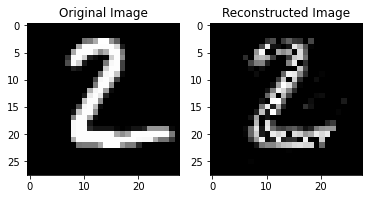

In [14]:
test_img = torch.index_select(test_images,0,torch.LongTensor([1]))

output_img = net((test_img.double().to(device))/255).data
output_img = (output_img*255).byte()
output_img = output_img.view(-1,28,28)
if device == 'cuda':
    outputImg = output_img.cpu()


test_img = test_img.view(-1,28,28)

fig = plt.figure()
plot=fig.add_subplot(1,2,1)
img = np.array(test_img.numpy())[0]
plot.set_title('Original Image')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,2,2)
img = np.array(outputImg.numpy())[0]
plot.set_title('Reconstructed Image')
imgplot = plt.imshow(img,cmap='gray')
plt.show()


**Visualizing Encoder Weights**

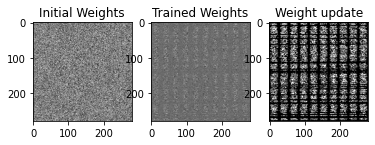

In [15]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5


if use_gpu:
    init_weights = init_weights.view(-1,280,280).byte().cpu()
    trained_weights = trained_weights.view(-1,280,280).byte().cpu()
else:
    init_weights = init_weights.view(-1,280,280).byte()
    trained_weights = trained_weights.view(-1,280,280).byte()

d_weights = init_weights - trained_weights 

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()


**Removing Decoder and Adding Classification Layer**

In [23]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 10),nn.LogSoftmax(dim=1)))
print(net)
net = net.double().to(device)
clf_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


**Defining Optimizer**

In [24]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

**Training Classifier**

In [26]:
iterations = 30
BatchSize = 1000
for epoch in range(iterations):
    runningLoss = 0
    for i in range(int(train_images.shape[0]/BatchSize)):
        inputs = torch.index_select(train_images,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(train_labels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
        
    inputs = train_images.double()/255    
    inputs = inputs.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    if device == 'cuda':
        predicted = predicted.cpu()
        
    correct = 0
    total = 0
    total += test_labels.size(0)
    #correct += (predicted == test_labels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f'%(epoch + 1,iterations,runningLoss/
                                                                            (train_images.shape[0]/
                                                                             BatchSize)))
print('Finished Training')


At Iteration: 1 / 30  ;  Training Loss: 0.835819
At Iteration: 2 / 30  ;  Training Loss: 0.304799
At Iteration: 3 / 30  ;  Training Loss: 0.262310
At Iteration: 4 / 30  ;  Training Loss: 0.240362
At Iteration: 5 / 30  ;  Training Loss: 0.225796
At Iteration: 6 / 30  ;  Training Loss: 0.215036
At Iteration: 7 / 30  ;  Training Loss: 0.206563
At Iteration: 8 / 30  ;  Training Loss: 0.199584
At Iteration: 9 / 30  ;  Training Loss: 0.193648
At Iteration: 10 / 30  ;  Training Loss: 0.188489
At Iteration: 11 / 30  ;  Training Loss: 0.183909
At Iteration: 12 / 30  ;  Training Loss: 0.179782
At Iteration: 13 / 30  ;  Training Loss: 0.176024
At Iteration: 14 / 30  ;  Training Loss: 0.172573
At Iteration: 15 / 30  ;  Training Loss: 0.169387
At Iteration: 16 / 30  ;  Training Loss: 0.166420
At Iteration: 17 / 30  ;  Training Loss: 0.163639
At Iteration: 18 / 30  ;  Training Loss: 0.161023
At Iteration: 19 / 30  ;  Training Loss: 0.158541
At Iteration: 20 / 30  ;  Training Loss: 0.156192
At Iterat

**Visualizing Encoder Weights**

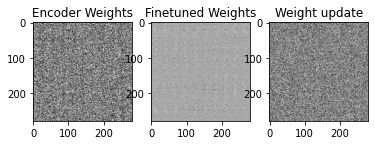

In [29]:
clf_weights_ft = copy.deepcopy(net[0][0].weight.data)
clf_weights = (1 + clf_weights)*127.5
clf_weights_ft = (1 + clf_weights_ft)*127.5

if use_gpu:
    clf_weights = clf_weights.view(-1,280,280).byte().cpu()
    clf_weights_ft = clf_weights_ft.view(-1,280,280).byte().cpu()
else:
    clf_weights = clf_weights.view(-1,280,280).byte()
    clf_weights_ft = clf_weights_ft.view(-1,280,280).byte()

d_weights = clf_weights - clf_weights_ft

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(clf_weights.numpy())[0]
plot.set_title('Encoder Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(clf_weights_ft.numpy())[0]
plot.set_title('Finetuned Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()


**Visualizing Classifier Weights**

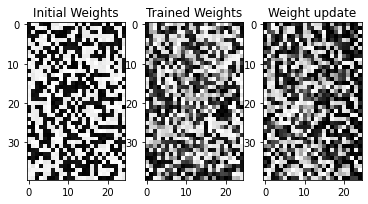

In [31]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)
init_classifier_weights = (1 + init_classifier_weights)*255
trained_classifier_weights = (1 + trained_classifier_weights)*255

if use_gpu:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte().cpu()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte().cpu()
else:
    init_classifier_weights = init_classifier_weights.view(-1,40,25).byte()
    trained_classifier_weights = trained_classifier_weights.view(-1,40,25).byte()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img,cmap='gray')

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img,cmap='gray')
plt.show()